<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fsentiment/applications/sentiment/Sentiment%20Analysis%20with%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import random
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator
from torchtext.datasets import IMDB

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
TEXT = Field(tokenize = 'spacy', include_lengths = True)
LABEL = LabelField(dtype = torch.float)

In [6]:
train_data, test_data = IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 10.6MB/s]


In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [8]:
print(vars(train_data.examples[0]))

{'text': ['i', 'read', 'the', 'book', '"', '7', 'years', 'in', 'Tibet', '"', 'from', 'Heinrich', 'Harrer', 'and', 'was', 'fascinated', 'of', 'it', '.', 'then', 'i', 'immediately', 'grabbed', 'the', 'DVD', 'and', 'started', 'to', 'watch', 'the', 'movie', '.', 'i', 'remember', 'the', 'first', 'time', 'i', 'saw', 'it', 'back', 'in', '98', ',', 'i', 'kinda', 'liked', 'it', '.', 'well', ',', 'now', 'i', 'watched', 'it', 'again', 'in', 'full', 'knowledge', 'of', 'the', 'book', 'it', 'is', 'based', 'on', '.', 'and', 'soon', 'i', 'realized', 'how', 'WRONG', 'it', 'all', 'was', 'told:<br', '/><br', '/>when', 'they', 'enter', 'Lhasa', 'the', 'people', 'start', 'to', 'stick', 'their', 'tongues', 'out', 'of', 'their', 'mouths', 'and', 'Thewlis', 'and', 'Pitt', 'have', 'the', 'impression', 'that', 'its', 'the', 'way', 'to', 'say', 'hello', 'in', 'Tibet', ',', 'so', 'they', 'greet', 'back', '...', 'in', 'the', 'book', 'Harrer', 'explains', ',', 'that', 'sticking', 'the', 'tongue', 'out', 'is', 'a', 

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [11]:
device

device(type='cuda')

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()

        self.pad_idx = pad_idx
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attn = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.v = nn.Linear(hidden_dim * 2, 1, bias = False)
        self.dropout = nn.Dropout(dropout)
    
    def create_mask(self, src):
        # src => [src_len, batch_size]

        mask = (src != self.pad_idx)
        mask = mask.permute(1, 0)
        # mask => [batch_size, src_len]
        
        return mask
    
    def forward(self, src, src_lengths):
        # src => [seq_len, batch_size]
        # src_lengths => [batch_size]

        batch_size = src.shape[1]
        
        mask = self.create_mask(src)
        # mask => [batch_size, seq_len]

        embedded = self.dropout(self.embedding(src))
        # embedded => [seq_len, batch_size, emb_dim]

        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)
        packed_outputs, (hidden, _) = self.rnn(packed_input)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs => [seq_len, batch_size, hidden_dim * 2]
        # hidden => [num_layers * num_dir, batch_size, hidden_dim]

        hidden = hidden.view(self.n_layers, 2, batch_size, -1)
        # [2, 2, b, h] => multi layer bi dir    => [-1][0]  [-1][1]
        #              => final layer forward hidden [-1][0][:] => [batch_size, hidden_dim]
        #              => final layer backward hidden [-1][1][:] => [batch_size, hidden_dim]

        # concatinating final forward and final backward hidden states
        hidden = torch.cat((hidden[-1][0][:], hidden[-1][1][:]), dim=1)
        hidden = self.dropout(hidden)
        # hidden => [batch_size, hidden_dim * 2]

        attention_energies = self.attention(hidden, outputs, mask)
        # attention_energies => [batch_size, seq_len]

        attention_energies = attention_energies.unsqueeze(1)
        # attention_energies => [batch_size, 1, seq_len]

        outputs = outputs.permute(1, 0 , 2)
        # outputs => [batch_size, seq_len, hidden_dim * 2]

        weighted = torch.bmm(attention_energies, outputs)
        # weighted => [batch_size, 1, hidden_dim * 2]

        weighted = weighted.squeeze(1)
        # weighted => [batch_size, hidden_dim * 2]

        logits = self.fc_out(weighted)
        # logits => [batch_size, output_dim]

        return logits, attention_energies.squeeze(1)
    
    def attention(self, hidden, outputs, mask):
        # hidden => [batch_size, hidden_dim * 2]
        # outputs => [seq_len, batch_size, hidden_dim * 2]
        # mask => [batch_size, seq_len]

        batch_size = outputs.shape[1]
        seq_len = outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # hidden => [batch_size, seq_len, hidden_dim * 2]

        outputs = outputs.permute(1, 0, 2)
        # outputs => [batch_size, seq_len, hidden_dim * 2]

        energy = torch.tanh(self.attn(torch.cat((hidden, outputs), dim = 2)))
        # energy => [batch_size, seq_len, hidden_dim * 2]

        attention_energy = self.v(energy).squeeze(2)
        # attention_energy => [batch_size, seq_len]

        attention_energy = attention_energy.masked_fill(mask == 0, -1e10)
        # attention_energy => [batch_size, seq_len]

        return F.softmax(attention_energy, dim=1)


In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(device)

In [14]:
# def init_weights(model):
#     for name, param in model.named_parameters():
#         nn.init.normal_(param.data, mean=0, std=0.01)
# model.apply(init_weights)
model

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc_out): Linear(in_features=512, out_features=1, bias=True)
  (attn): Linear(in_features=1024, out_features=512, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable paramters')

The model has 5336169 trainable paramters


In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    predicted = torch.round(torch.sigmoid(preds))
    correct = (predicted == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()

        input, input_lengths = batch.text
        preds, _ = model(input, input_lengths)
        preds = preds.squeeze(1)

        loss = criterion(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    for batch in iterator:
        input, input_lengths = batch.text
        preds, _ = model(input, input_lengths)
        preds = preds.squeeze(1)
        loss = criterion(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 57s
	Train Loss: 0.589 | Train Acc: 67.47%
	 Val. Loss: 0.454 |  Val. Acc: 79.28%
Epoch: 02 | Epoch Time: 1m 57s
	Train Loss: 0.430 | Train Acc: 80.57%
	 Val. Loss: 0.351 |  Val. Acc: 84.67%
Epoch: 03 | Epoch Time: 1m 57s
	Train Loss: 0.352 | Train Acc: 85.02%
	 Val. Loss: 0.351 |  Val. Acc: 85.21%
Epoch: 04 | Epoch Time: 1m 56s
	Train Loss: 0.298 | Train Acc: 87.74%
	 Val. Loss: 0.312 |  Val. Acc: 88.06%
Epoch: 05 | Epoch Time: 1m 56s
	Train Loss: 0.257 | Train Acc: 89.71%
	 Val. Loss: 0.296 |  Val. Acc: 87.96%
Test Loss: 0.297 | Test Acc: 87.74%


In [0]:
nlp = spacy.load('en')

def inference(model, sentence):
    model.eval()
    if isinstance(sentence, str):
        tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    else:
        tokenized = sentence
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    with torch.no_grad():
        logits, attention = model(tensor, length_tensor)
    prediction = torch.sigmoid(logits)
    return tokenized, prediction.item(), attention.squeeze()

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def display_attention(labels, attention):
    attention = attention.cpu().detach().numpy()
    attention = np.around(attention, 4)
    fig, ax = plt.subplots()
    im = ax.imshow([attention])
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels("")
    for i in range(len(labels)):
        text = ax.text(i, 0, attention[i], ha="center", va="center", color="w")
    plt.show()
    plt.close()

Review: The film worth an oscar award
predicted sentiment: 0.999


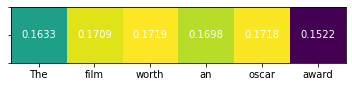

In [65]:
review = "The film worth an oscar award"
tokens, predicted, attention = inference(model, review)
print(f"Review: {review}")
print(f"predicted sentiment: {predicted:.3f}")
display_attention(tokens, attention)

Review: The movie was absolutely unwatchable
predicted sentiment: 0.001


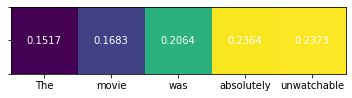

In [66]:
review = "The movie was absolutely unwatchable"
tokens, predicted, attention = inference(model, review)
print(f"Review: {review}")
print(f"predicted sentiment: {predicted:.3f}")
display_attention(tokens, attention)

In [0]:
def display_attention_seaborn(labels, attention):
    attention = attention.cpu().detach().numpy()
    attention = np.around(attention, 4)
    fig, ax = plt.subplots(figsize=(10, 2))
    ax = sns.heatmap([attention], vmin=0, vmax=1, annot=True, xticklabels=labels, yticklabels=False)
    plt.show()
    plt.close()

0.9993519186973572


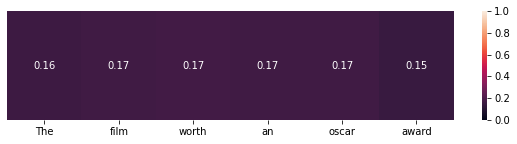

In [58]:
tokens, predicted, attention = inference(model, "The film worth an oscar award")
print(predicted)
display_attention_seaborn(tokens, attention)

0.000571692711673677


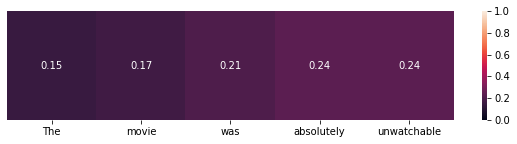

In [59]:
tokens, predicted, attention = inference(model, "The movie was absolutely unwatchable")
print(predicted)
display_attention_seaborn(tokens, attention)